In [1]:
"""Investigate how do the frequency of application affects things
"""
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [2]:
path_out = os.path.join(os.environ['E3SM_ROOT'], 'output')
case_prefix = '20241203_UIEF_ICB20TRCNPRDCTCBC_3year_rmethod1_'
suffix_list = ['appEveryYearerw', 'app2Yearerw', 'app5Yearerw', 'app10Yearerw']
year_list = range(1950, 2023)
dzsoi = np.array([0.0175, 0.0276, 0.0455, 0.0750, 0.1236, 0.2038, 0.3360, 0.5539, 0.9133, 1.5058])
cation_name = ['Ca', 'Mg', 'Na', 'K', 'Al']
cation_mass = [40, 24, 23, 39, 27]
cation_valence = [2, 2, 1, 1, 3]

# fluxes
primary_mineral_collect = np.full([365 * len(year_list), len(suffix_list)], np.nan)
r_dissolve_collect = np.full([365 * len(year_list), len(suffix_list)], np.nan)
r_sequestration_collect = np.full([365 * len(year_list), len(suffix_list)], np.nan)
r_cec_collect = np.full([365 * len(year_list), len(suffix_list)], np.nan)
r_precip_collect = np.full([365 * len(year_list), len(suffix_list)], np.nan)
r_leach_collect = np.full([365 * len(year_list), len(suffix_list), 4], np.nan)

# state variables
soil_ph = np.full([365 * len(year_list), len(suffix_list)], np.nan)
base_saturation = np.full([365 * len(year_list), len(suffix_list)], np.nan)
calcite = np.full([365 * len(year_list), len(suffix_list)], np.nan)

# accounting: how much rock applied? 10 kg m-2 * 0.12
rock_applied = np.full([365 * len(year_list), len(suffix_list)], np.nan)


#
flist_default = [
    os.path.join(path_out, f'{case_prefix}appCtrlerw', 'run',
                    f'{case_prefix}appCtrlerw.elm.h1.{year}-01-01-00000.nc') \
    for year in year_list
]

for i, suffix in enumerate(suffix_list):
    flist = [
        os.path.join(path_out, f'{case_prefix}{suffix}', 'run',
                     f'{case_prefix}{suffix}.elm.h1.{year}-01-01-00000.nc') \
        for year in year_list
    ]

    for j, (file, file2) in enumerate(zip(flist, flist_default)):
        nc = Dataset(file, 'r')

        # g m-2
        primary_mineral_collect[(j*365):(j*365+365), i] = nc['primary_mineral'][:, 1, 0]

        # kg m-2 year-1 => g m-2 year-1
        rock_applied[(j*365):(j*365+365), i] = nc['forc_app'][:, 0] * 1000.

        # g m-2 s-1
        r_dissolve_collect[(j*365):(j*365+365), i] = nc['primary_cation_flux'][:, 1, 0]

        nc2 = Dataset(file2, 'r')

        # gC m-2 s-1
        r_sequestration_collect[(j*365):(j*365+365), i] = \
             (nc['r_sequestration'][:, 0] - nc2['r_sequestration'][:, 0])

        # g m-2 s-1
        # rate at which adsorbed cation is released into water (negative for adsorption into soil)
        # Need to subtract out background level for this to work
        r_cec_collect[(j*365):(j*365+365), i] = \
            np.sum((nc['cec_cation_flux_vr_2'][:, :10, 0] - \
                    nc2['cec_cation_flux_vr_2'][:, :10, 0]) * dzsoi, axis = 1)

        # g m-2 s-1
        r_precip_collect[(j*365):(j*365+365), i] = \
            (nc['secondary_cation_flux'][:, 1, 0] - nc2['secondary_cation_flux'][:, 1, 0])

        # 
        soil_ph[(j*365):(j*365+365), i] = \
            np.sum(nc['soil_pH'][:, :5, 0] * dzsoi[:5], axis = 1) / np.sum(dzsoi[:5])

        # total CEC: meq 100g-1 dry soil
        cec_tot = nc['cect_col'][:, :10, 0]
        # bulk density: kg cm-3
        bd_col = nc['bd_col'][:, :10, 0]
        # g m-3 soil => fraction of total CEC
        fraction = np.full([365, 10, 4], np.nan)
        for icat in range(4):
            fraction[:, :, icat] = nc[f'cec_cation_vr_{icat+1}'][:, :10, 0] * \
                100 * cation_valence[icat] / cation_mass[icat] / bd_col / cec_tot
        fraction = np.sum(fraction, axis = 2)

        base_saturation[(j*365):(j*365+365), i] = \
            np.sum(fraction * dzsoi, axis = 1) / np.sum(dzsoi)

        # g m-2
        calcite[(j*365):(j*365+365), i] = nc['secondary_mineral'][:, 0, 0] - \
           nc2['secondary_mineral'][:, 0, 0]

        # g m-2 s-1
        for icat in range(4):
            r_leach_collect[(j*365):(j*365+365), i, icat] = \
                (nc['cation_leached'][:,icat,0] - nc2['cation_leached'][:,icat,0])

        nc2.close()
        nc.close()

/tmp/ipykernel_3536439/1561810245.py:16: RuntimeWarning: invalid value encountered in divide
  dissolve_level = r_dissolve_collect[:, i] * 86400 * 365 / primary_mineral_collect[:, i]
/tmp/ipykernel_3536439/1561810245.py:32: RuntimeWarning: invalid value encountered in divide
  r_level = np.cumsum(r_sequestration_collect[:, i]) / np.cumsum(r_dissolve_collect[:, i])
/tmp/ipykernel_3536439/1561810245.py:45: RuntimeWarning: invalid value encountered in divide
  dissolve_level = - np.cumsum(r_cec_collect[:, i]) / np.cumsum(r_dissolve_collect[:, i])


"\n# This term is zero for Mg because we don't have MgCO3\nax = axes.flat[4]\nfor i, suffix in enumerate(suffix_list):\n    #dissolve_level = - np.convolve(r_precip_collect[:, i], np.ones(365)/365, mode = 'same')     #    / np.convolve(r_dissolve_collect[:, i], np.ones(365)/365, mode = 'same')\n    #dissolve_level[:365] = np.nan\n    #dissolve_level[-365:] = np.nan\n    dissolve_level = - np.cumsum(r_precip_collect[:, i]) / np.cumsum(r_dissolve_collect[:, i])\n    dissolve_level[:365] = np.nan\n    ax.plot(dissolve_level, label = suffix)\n    ax.set_title('Cumulative Mg flux into secondary mineral \n/ Mg dissolution flux (g Mg / g Mg)')\n#ax.set_yscale('log')\nax.grid(True, axis = 'x')"

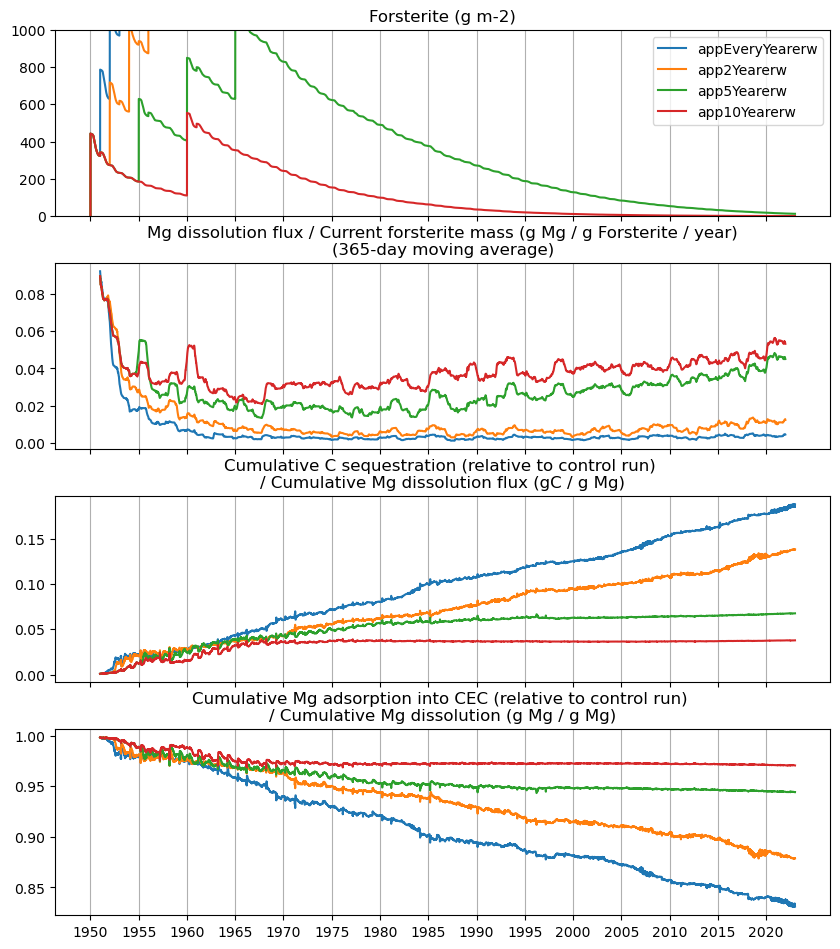

In [5]:
fig, axes = plt.subplots(4, 1, figsize = (10, 11.5), sharex = True)
fig.subplots_adjust(hspace = 0.25)

ax = axes.flat[0]
for i, suffix in enumerate(suffix_list):
    ax.plot(primary_mineral_collect[:, i], label = suffix)
    ax.set_title('Forsterite (g m-2)')
    ax.legend() # loc = (1.05, 0.5))
ax.set_xticks(range(0, primary_mineral_collect.shape[0], 365*5))
ax.set_xticklabels(year_list[::5])
ax.grid(True, axis = 'x')
ax.set_ylim([0, 1000])

ax = axes.flat[1]
for i, suffix in enumerate(suffix_list):
    dissolve_level = r_dissolve_collect[:, i] * 86400 * 365 / primary_mineral_collect[:, i]
    dissolve_level = np.convolve(dissolve_level, np.ones(365)/365, mode='same')
    dissolve_level[:365] = np.nan
    dissolve_level[-365:] = np.nan
    ax.plot(dissolve_level, label = suffix)
    ax.set_title('Mg dissolution flux / Current forsterite mass (g Mg / g Forsterite / year)\n'+
                 '(365-day moving average)')
#ax.set_yscale('log')
ax.grid(True, axis = 'x')

ax = axes.flat[2]
for i, suffix in enumerate(suffix_list):
    #r_level = np.convolve(r_sequestration_collect[:, i], np.ones(365)/365) / \
    #          np.convolve(r_dissolve_collect[:, i], np.ones(365)/365)
    #r_level[:365] = np.nan
    #r_level[-365:] = np.nan
    r_level = np.cumsum(r_sequestration_collect[:, i]) / np.cumsum(r_dissolve_collect[:, i])
    r_level[:365] = np.nan
    ax.plot(r_level, label = suffix)
    ax.set_title('Cumulative C sequestration (relative to control run) \n/ Cumulative Mg dissolution flux (gC / g Mg)')
#ax.set_yscale('symlog', linthresh = 0.1)
ax.grid(True, axis = 'x')

ax = axes.flat[3]
for i, suffix in enumerate(suffix_list):
    #dissolve_level = - np.convolve(r_cec_collect[:, i], np.ones(365)/365, mode = 'same') \
    #    / np.convolve(r_dissolve_collect[:, i], np.ones(365)/365, mode = 'same')
    #dissolve_level[:365] = np.nan
    #dissolve_level[-365:] = np.nan
    dissolve_level = - np.cumsum(r_cec_collect[:, i]) / np.cumsum(r_dissolve_collect[:, i])
    dissolve_level[:365] = np.nan
    ax.plot(dissolve_level, label = suffix)
    ax.set_title('Cumulative Mg adsorption into CEC (relative to control run) \n/ Cumulative Mg dissolution (g Mg / g Mg)')
#ax.set_yscale('log')
ax.grid(True, axis = 'x')

"""
# This term is zero for Mg because we don't have MgCO3
ax = axes.flat[4]
for i, suffix in enumerate(suffix_list):
    #dissolve_level = - np.convolve(r_precip_collect[:, i], np.ones(365)/365, mode = 'same') \
    #    / np.convolve(r_dissolve_collect[:, i], np.ones(365)/365, mode = 'same')
    #dissolve_level[:365] = np.nan
    #dissolve_level[-365:] = np.nan
    dissolve_level = - np.cumsum(r_precip_collect[:, i]) / np.cumsum(r_dissolve_collect[:, i])
    dissolve_level[:365] = np.nan
    ax.plot(dissolve_level, label = suffix)
    ax.set_title('Cumulative Mg flux into secondary mineral \n/ Mg dissolution flux (g Mg / g Mg)')
#ax.set_yscale('log')
ax.grid(True, axis = 'x')"""

/tmp/ipykernel_3231553/4291880895.py:27: RuntimeWarning: invalid value encountered in divide
  rel_sequester = np.cumsum(r_sequestration_collect[:, i] * 86400) / np.cumsum(rock_applied[:, i])


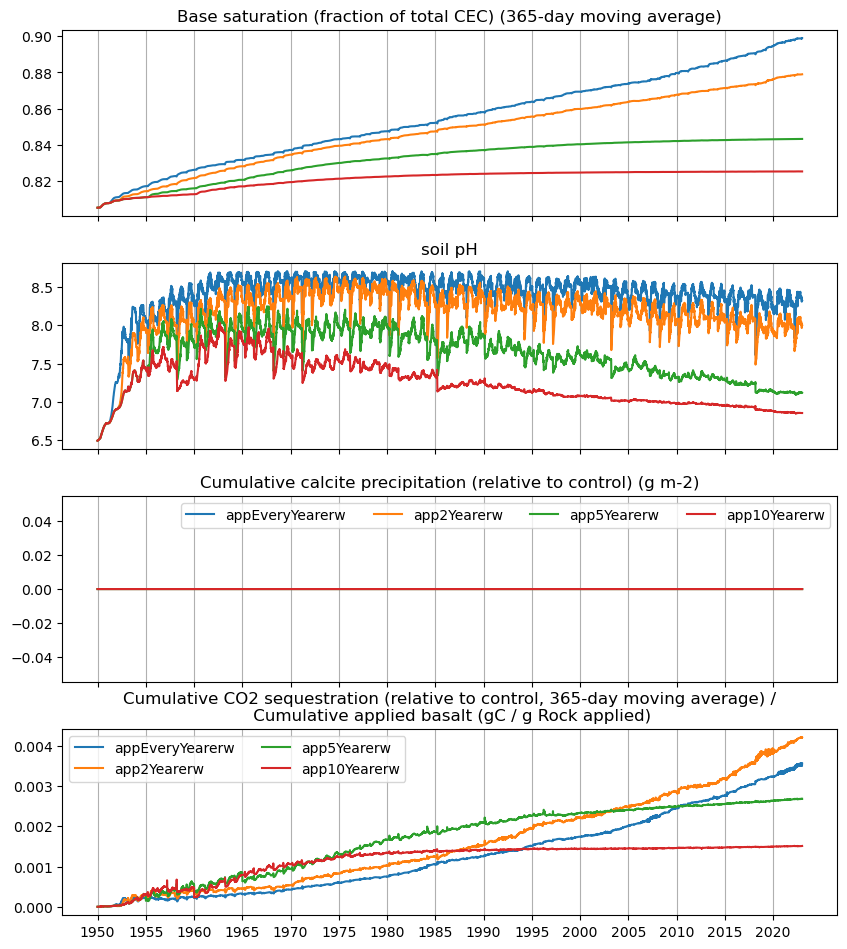

In [40]:
fig, axes = plt.subplots(4, 1, figsize = (10, 11.5), sharex = True)
fig.subplots_adjust(hspace = 0.25)

ax = axes.flat[0]
for i, suffix in enumerate(suffix_list):
    ax.plot(base_saturation[:,i], label = suffix)
    ax.set_title('Base saturation (fraction of total CEC) (365-day moving average)')
ax.grid(True, axis = 'x')

ax = axes.flat[1]
for i, suffix in enumerate(suffix_list):
    ax.plot(soil_ph[:, i], label = suffix)
    ax.set_title('soil pH') # (relative to control)
ax.grid(True, axis = 'x')

ax = axes.flat[2]
for i, suffix in enumerate(suffix_list):
    ax.plot(np.cumsum(calcite[:, i]), label = suffix)
    ax.set_title('Cumulative calcite precipitation (relative to control) (g m-2)')
    ax.legend(ncol = 4)
ax.set_xticks(range(0, calcite.shape[0], 365*5))
ax.set_xticklabels(year_list[::5])
ax.grid(True, axis = 'x')

ax = axes.flat[3]
for i, suffix in enumerate(suffix_list):
    rel_sequester = np.cumsum(r_sequestration_collect[:, i] * 86400) / np.cumsum(rock_applied[:, i])
    ax.plot(rel_sequester, label = suffix)
    ax.set_title('Cumulative CO2 sequestration (relative to control, 365-day moving average) /\n Cumulative applied basalt (gC / g Rock applied)')
    ax.legend(ncol = 2)
ax.set_xticks(range(0, calcite.shape[0], 365*5))
ax.set_xticklabels(year_list[::5])
ax.grid(True, axis = 'x')

/tmp/ipykernel_3231553/2630546515.py:6: RuntimeWarning: invalid value encountered in divide
  ax.plot((np.cumsum(r_leach_collect[:, i, icat]) / cation_mass[icat] * \
/tmp/ipykernel_3231553/2630546515.py:6: RuntimeWarning: invalid value encountered in divide
  ax.plot((np.cumsum(r_leach_collect[:, i, icat]) / cation_mass[icat] * \
/tmp/ipykernel_3231553/2630546515.py:6: RuntimeWarning: invalid value encountered in divide
  ax.plot((np.cumsum(r_leach_collect[:, i, icat]) / cation_mass[icat] * \
/tmp/ipykernel_3231553/2630546515.py:6: RuntimeWarning: invalid value encountered in divide
  ax.plot((np.cumsum(r_leach_collect[:, i, icat]) / cation_mass[icat] * \


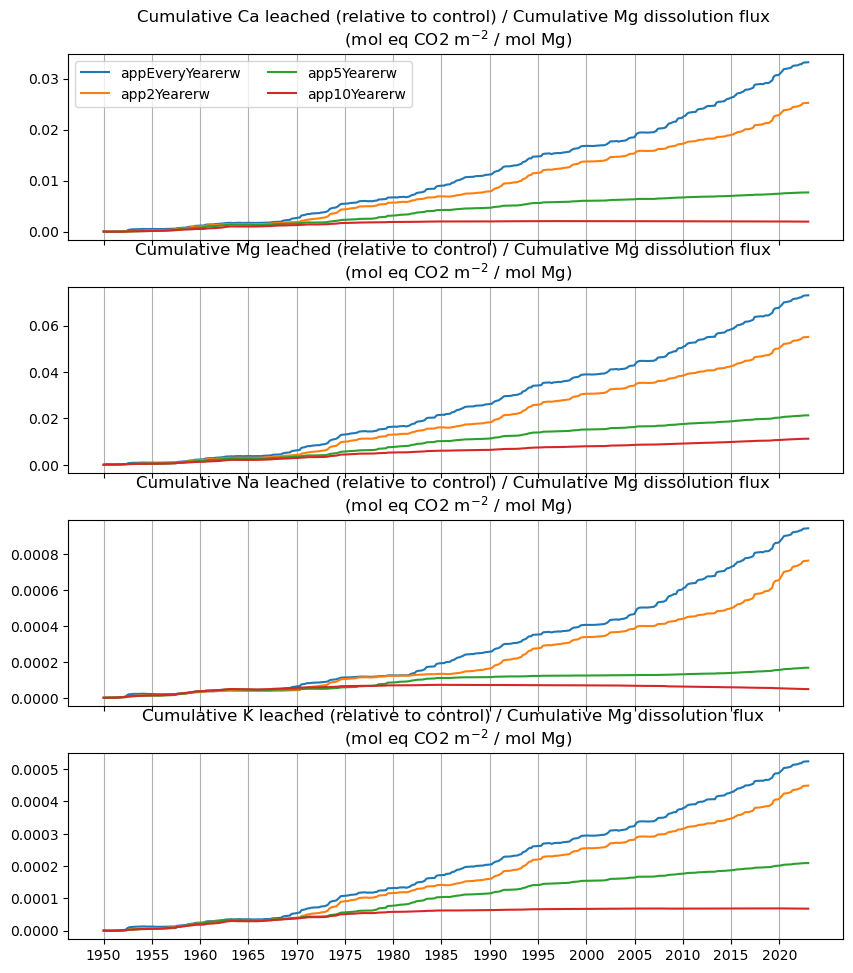

In [25]:
fig, axes = plt.subplots(4, 1, figsize = (10, 11.5), sharex = True)
fig.subplots_adjust(hspace = 0.25)
for icat in range(4):
    ax = axes.flat[icat]
    for i, suffix in enumerate(suffix_list):
        ax.plot((np.cumsum(r_leach_collect[:, i, icat]) / cation_mass[icat] * \
                 cation_valence[icat]) / \
                (np.cumsum(r_dissolve_collect[:, i]) / cation_mass[1]), label = suffix)
    ax.set_title('Cumulative ' + cation_name[icat] + \
                 ' leached (relative to control) / Cumulative Mg dissolution flux \n (mol eq CO2 m$^{-2}$ / mol Mg)')
    ax.set_xticks(range(0, r_leach_collect.shape[0], 365*5))
    ax.set_xticklabels(year_list[::5])
    ax.grid(True, axis = 'x')
    if icat == 0:
        ax.legend(ncol = 2)

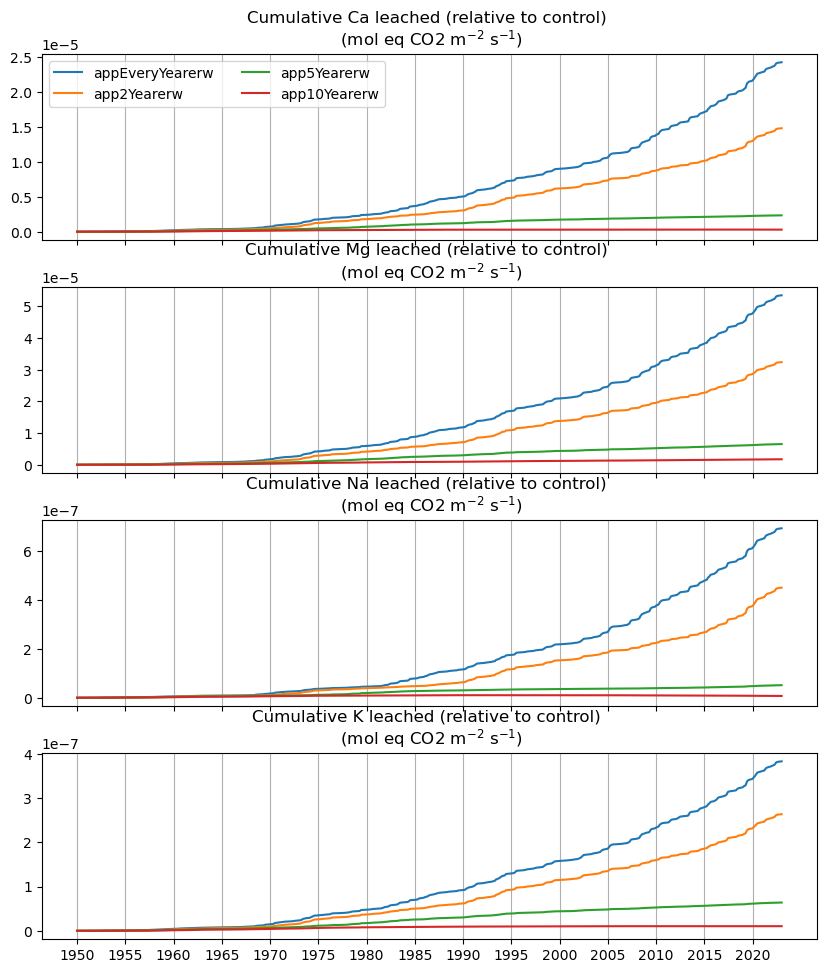

In [7]:
fig, axes = plt.subplots(4, 1, figsize = (10, 11.5), sharex = True)
fig.subplots_adjust(hspace = 0.25)
for icat in range(4):
    ax = axes.flat[icat]
    for i, suffix in enumerate(suffix_list):
        ax.plot((np.cumsum(r_leach_collect[:, i, icat]) / cation_mass[icat] * \
                 cation_valence[icat]), label = suffix)
    ax.set_title('Cumulative ' + cation_name[icat] + \
                 ' leached (relative to control) \n (mol eq CO2 m$^{-2}$ s$^{-1}$)')
    ax.set_xticks(range(0, r_leach_collect.shape[0], 365*5))
    ax.set_xticklabels(year_list[::5])
    ax.grid(True, axis = 'x')
    if icat == 0:
        ax.legend(ncol = 2)